In [1]:
from keras.models import model_from_json
import os
import numpy as np
from scipy import misc
from tqdm import tqdm
import h5py
import pandas as pd

Using TensorFlow backend.


In [2]:
# 将模型加载

In [3]:
model_xce = model_from_json(open('xception.json').read())    
model_xce.load_weights('Xception_fine_tune06-0.01.h5') 

In [4]:
model_inc = model_from_json(open('inceptionV3.json').read())
model_inc.load_weights('Inception_V302-0.02.h5')

In [4]:
model_res = model_from_json(open('ResNet50.json').read())    
model_res.load_weights('resnet50_ft01-0.03.h5')

In [7]:
# 加载测试集

In [8]:
n = 25000
filenames = os.listdir('../test')
file_ob_path = [os.path.join('../test',file) for file in filenames]
n = len(file_ob_path)

X_test = np.zeros((n, 299, 299, 3), dtype=np.uint8)
X_test_2 = np.zeros((n, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(n)):
    
    X_test[i] = misc.imresize(misc.imread(file_ob_path[i]), (299,299))
    X_test_2[i] = misc.imresize(misc.imread(file_ob_path[i]), (224,224))

100%|██████████| 12500/12500 [03:21<00:00, 62.07it/s]


In [9]:
X_test_2 = X_test_2[..., ::-1]
X_test_2[..., 0] -= 103.939
X_test_2[..., 1] -= 116.779
X_test_2[..., 2] -= 123.68

In [10]:
# 结果预测

In [11]:
y_pred_xce = model_xce.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 1061s  


In [12]:
y_pred_inc = model_inc.predict(X_test,batch_size=16, verbose=1)


12500/12500 [==============================] - 683s   


In [13]:
y_pred_res = model_res.predict(X_test_2,batch_size=16, verbose=1)

12500/12500 [==============================] - 534s   


# 模型融合

In [14]:
## 定义提交结果的函数

In [15]:
def submission(y_pred,res):
    y_pred = y_pred.clip(min=0.005, max=0.995)
    _id = [int(i.split('.')[0]) for i in filenames]
    df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
    df = df.sort_values(by='id')
    df.to_csv('%s.csv'%res,index=False)

## 三个模型平均

In [19]:
y_pred_avg_1 = (y_pred_xce+y_pred_inc+y_pred_res)/3

In [20]:
submission(y_pred_avg_1,'y_pred_avg_1')

In [17]:
# 0.04264

## 三个模型加权平均融合

In [21]:
a1 = (1-0.04266)/(3-0.04266-0.05190-0.05376)
a2 = (1-0.05190)/(3-0.04266-0.05190-0.05376)
a3 = (1-0.05376)/(3-0.04266-0.05190-0.05376)

In [22]:
y_pred_avg_2 = a1*y_pred_xce+a2*y_pred_inc+a3*y_pred_res

In [24]:
submission(y_pred_avg_2,'y_pred_avg_2')

In [ ]:
# 0.04262

## xception 和 InceptionV3 融合

## 加权平均

In [25]:
a1 = (1-0.04266)/(2-0.04266-0.05190)
a2 = (1-0.05190)/(2-0.04266-0.05190)

In [26]:
y_pred_avg_3 =  a1*y_pred_xce+a2*y_pred_inc

In [27]:
submission(y_pred_avg_3,'y_pred_avg_3')

In [ ]:
# 0.04134

## 平均

In [28]:
y_pred_avg_4 =  (y_pred_xce+y_pred_inc)/2

In [29]:
submission(y_pred_avg_4,'y_pred_avg_4')

In [ ]:
# 0.04136

# 测试

In [5]:
import matplotlib.pyplot as plt

In [6]:
from scipy import misc

In [23]:
def pred(x):
    a1 = (1-0.04266)/(2-0.04266-0.05190)
    a2 = (1-0.05190)/(2-0.04266-0.05190)
    y_pred_xce = model_xce.predict(np.expand_dims(x, axis=0),batch_size=1)
    y_pred_inc = model_inc.predict(np.expand_dims(x, axis=0),batch_size=1)
    res = a1*y_pred_xce+a2*y_pred_inc
    return res   

In [24]:
pict = [os.path.join('test_picture',i) for i in os.listdir('test_picture')]

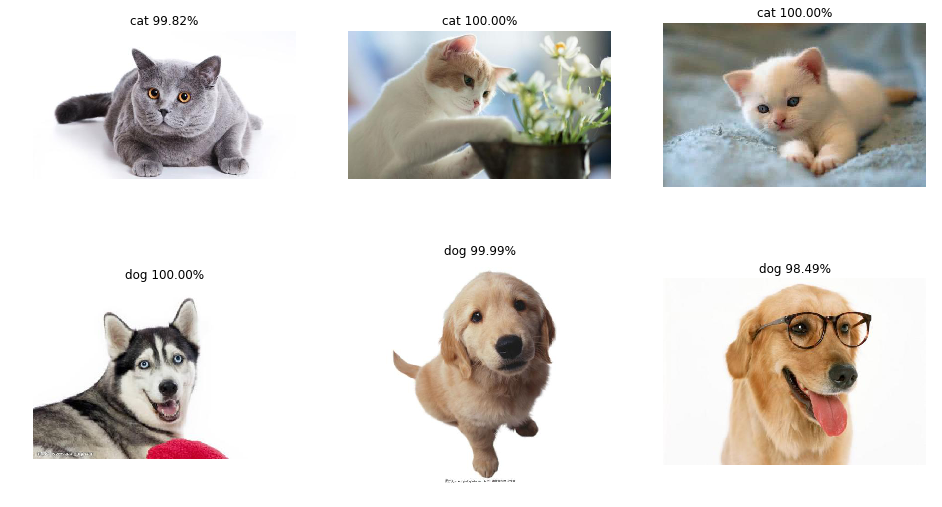

In [30]:
fig = plt.figure(figsize=(16, 9))
for i,pic in enumerate(pict):
    plt.subplot(2, 3, i+1)
    img = misc.imread(pic)
    img_pre = misc.imresize(img, (299, 299))
    prediction = pred(img_pre)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    plt.axis('off')
    plt.imshow(img)
plt.show()